## Set random seed to get more reproducible result

In [1]:
from numpy.random import seed
seed(2)
from tensorflow.random import set_seed
set_seed(2)

## Import libraries and functions

In [3]:
import os
import numpy as np
import pandas as pd

from expert.src.utils import read_genus_abu, read_labels, load_otlg, zero_weight_unk, parse_otlg, get_dmax
from expert.src.preprocessing import *
from expert.src.model import *
from expert.CLI.CLI_utils import find_pkg_resource as find_expert_resource

from tensorflow.keras.layers import Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.initializers import HeUniform, GlorotUniform

In [239]:
for exp, season in enumerate(['2013-LD', '2014-EW', '2014-LW', '2014-ED', '2014-LD']):
    queries = meta[(meta.Age >= 18)&(meta.Age < 50)].groupby(by='SEASON').sample(frac=0.5).SampleID
    meta[meta.SampleID.isin(queries)].to_csv('experiments/exp_{}/QueryMapper.csv'.format(exp))
    abu[queries].to_csv('experiments/exp_{}/QueryCM.tsv'.format(exp), sep='\t')
    meta[~meta.SampleID.isin(queries)].to_csv('experiments/exp_{}/SourceMapper.csv'.format(exp))
    abu.loc[:, ~abu.columns.to_series().isin(queries)].to_csv('experiments/exp_{}/SourceCM.tsv'.format(exp), sep='\t')

## Construct ontology using mapper file of source samples

In [32]:
!expert construct -i microbiomes.txt -o ontology.pkl

Reading microbiome structure...
Generating Ontology...
100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 10420.63it/s]
root
├── root:D
└── root:W

Done


## Preprocess the data, using EXPERT's command-line API 

In [241]:
%%bash

for i in {0,1,2,3,4}; do
ls experiments/exp_$i/SourceCM.tsv > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/SourceCM.h5;
ls experiments/exp_$i/QueryCM.tsv > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/QueryCM.h5;
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/SourceMapper.csv -o experiments/exp_$i/SourceLabels.h5;
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/QueryMapper.csv -o experiments/exp_$i/QueryLabels.h5;
done
rm tmp

running...
Reading and concatenating data, this could be slow if you have huge amount of data
db file: /home/chonghui/.etetoolkit/taxa.sqlite
       SRR5760852  SRR5760856  SRR5760857  ...  SRR5761189  SRR5761191  SRR5761196
count  487.000000  487.000000  487.000000  ...  487.000000  487.000000  487.000000
mean     0.341040    0.333661    0.341525  ...    0.344657    0.274692    0.337987
std      3.542116    3.905181    2.892207  ...    2.649880    2.076948    4.130398
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
max     56.613300   81.312616   47.043407  ...   38.901994   36.390414   84.659529

[6 rows x 166 columns]
Initializing in-memory taxonomy database for ultra-fast querying.
db file: /home/chonghui/.etetoolkit/taxa.sqlite
There will be 0/487 entries droped cause they are not in NCBI taxanomy database
Series([], dtype: object)
Extracting lineages for taxonomic

100%|██████████| 2/2 [00:00<00:00, 45.93it/s]


## Visualize the evaluation result

In [243]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

metadata = pd.read_csv('dataFiles/samples_meta_new.csv').set_index('SampleID')
metadata['COLLECTION_DATE'] = pd.to_datetime(metadata.COLLECTION_DATE)
metadata['COLLECTION_DATE_'] = metadata.COLLECTION_DATE.dt.year.astype(str) + '-' + \
    metadata.COLLECTION_DATE.dt.month.astype(str).str.rjust(2, '0') + '-' + \
    metadata.COLLECTION_DATE.dt.day.astype(str).str.rjust(2, '0')
sorted_months = metadata.COLLECTION_DATE.sort_values().copy()

c1 = pd.concat([pd.read_csv('experiments/exp_{}/Search_Transfer_DM/layer-2.csv'.format(i), index_col=0) for i in range(5)])
#c2 = pd.concat([pd.read_csv('experiments/exp_{}/Search_Transfer_DM/layer-2.csv'.format(i), index_col=0).join(metadata, how='left').rename(index=lambda x: x+'_exp'+str(i)) for i in range(5)])

c1 = c1.join(metadata, how='left')
c1['group'] = 'reference'
c1['realdata'] = True
c1['SEASON_'] = c1['SEASON'].apply(lambda x: x.split('-')[1])

In [248]:
pd.concat([pd.read_csv('experiments/exp_{}/Eval_Transfer_DM/overall.csv'.format(i), index_col=0) for i in range(5)]).mean()

ROC-AUC    0.82239
F-max      0.78029
dtype: float64

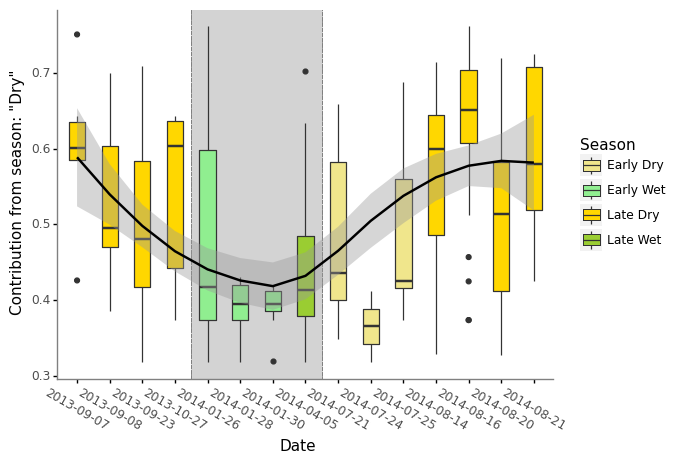

<ggplot: (8778158013471)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 7.68 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure.pdf


In [246]:
from plotnine import *

plot = (ggplot(c1, aes(x='COLLECTION_DATE_', y='root:D'))
        + geom_rect(xmin=4.5, xmax=8.5, ymin=0.2, ymax=1.0, alpha=0.1, color='gray', linetype='dashed', size=0.4, fill='lightgray')
        + geom_boxplot(aes(fill='SEASON_', group='COLLECTION_DATE_'), show_legend=True, width=0.5)
        + scale_fill_manual(['khaki','lightgreen','gold','yellowgreen'], name = "Season", labels = ["Early Dry", "Early Wet", "Late Dry", "Late Wet"])
        #+ scale_fill_discrete(name = "Season", labels = ["Early Dry", "Early Wet", "Late Dry", "Late Wet"])
        #+ geom_boxplot(aes(group='Timepoint_str'), fill='white', alpha=0.5, show_legend=False, outlier_shape='', data=data[data.People != 'MT10'], width=0.4)
        + geom_smooth(aes(group='group'), se=True, method='loess', show_legend=True)
        #+ scale_linetype_manual(['solid', 'dashdot'])
        #+ geom_point(aes(color='SEASON_'), shape='o')
        
        #+ geom_point(color='red', data=c2, shape='o', size=3)
        #+ scale_color_manual(['brown', "black"])
        + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
             axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1),
             axis_text_x=element_text(rotation=-30, hjust=0.5))
        #+ geom_hline(yintercept=, linetype="dotted")
        #+ geom_vline(xintercept=[4.5, 8.5], linetype="dashed", size=0.6)
        #+ geom_label(data='Early back', position=[15.5, 0.2])
        #+ scale_x_discrete(limits=['2013-LD', '2014-EW', '2014-LW', '2014-ED', '2014-LD'])
        + xlab('Date')
        + ylab('Contribution from season: "Dry"')
)

print(plot)
plot.save('Figure.pdf', dpi=120, width=6.4*1.2, height=4.8)

In [96]:
psuedo_contribution1 = c1.copy()
psuedo_contribution1['SEASON'] = psuedo_contribution1.SEASON.str.replace('2014', '2015').str.replace('2013', '2014')
psuedo_contribution1.SEASON.unique()
psuedo_contribution1['realdata'] = False
psuedo_contribution2 = c1.copy()
psuedo_contribution2['SEASON'] = psuedo_contribution2.SEASON.str.replace('2013', '2012').str.replace('2014', '2013')
psuedo_contribution2.SEASON.unique()
psuedo_contribution2['realdata'] = False

In [113]:
from plotnine import *
plot = (ggplot(pd.concat([c1, psuedo_contribution1, psuedo_contribution2]), aes(x='SEASON', y='root:W'))
        #+ geom_boxplot(aes(fill='Env', group='SEASON'), outlier_shape='', show_legend=True)
        + geom_violin(aes(fill='SEASON_', group='SEASON'), show_legend=True, data=c1)
        + scale_fill_manual(["#4DBBD5FF", "#E64B35FF",  "#00A087FF", "#F39B7FFF","#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"])
        #+ geom_boxplot(aes(group='Timepoint_str'), fill='white', alpha=0.5, show_legend=False, outlier_shape='', data=data[data.People != 'MT10'], width=0.4)
        + geom_smooth(aes(alpha='realdata', group='group'), se=True, method='loess', show_legend=False, span=0.5)
        #+ geom_smooth(aes(group='group'), se=True, method='loess', show_legend=True, data=psuedo_contribution)
        #+ scale_linetype_manual(['solid', 'dashdot'])
        + geom_point(aes(shape='realdata'), color='black', show_legend=False)
        + scale_shape_manual(['.', 'o'])
        #+ geom_point(color='red', data=c2, shape='o', size=3)
        + scale_color_manual(['brown', "black"])
        + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
             axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1), 
                axis_text_x=element_text(rotation=-30, hjust=0.5))
        #+ geom_hline(yintercept=, linetype="dotted")
        #+ geom_vline(xintercept=[1, 2, 3, 4, 5], linetype="dashed", size=0.6)
        #+ geom_label(data='Early back', position=[15.5, 0.2])
        + scale_x_discrete(limits=['2012-LD', '2013-EW', '2013-LW', '2013-ED', '2013-LD', '2014-EW', '2014-LW', '2014-ED', '2014-LD', '2015-EW', '2015-LW', '2015-ED', '2015-LD'])
        + xlab('Season')
        + ylab('Contribution from season: "Wet"')
)

print(plot)
plot.save('Figure.pdf', dpi=120, width=6.4*1, height=4.8)

/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/scales/scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.


ValueError: b'There are other near singularities as well. 1\n'

In [428]:
meta[meta.SUBJECT_ID == 5]

,SampleID,study_accession,sample_alias,#SampleID,Gender,Age,COLLECTION_DATE,SEASON,BUSH_CAMP,Metagenomics,SEASONALITY_UNIQUE_ONLY_1,8_individuals,SUBJECT_ID,Env
60,SRR5760942,PRJNA392012,TZ_HADZA_267,267,FEMALE,45.0,1/30/2014,2014-EW,SENGELI,No,No,No,5,root:W
71,SRR5760958,PRJNA392012,TZ_HADZA_227,227,FEMALE,45.0,1/28/2014,2014-EW,SENGELI,No,No,No,5,root:W
132,SRR5761074,PRJNA392012,TZ_HADZA_139,139,FEMALE,45.0,9/7/2013,2013-LD,SENGELI,No,No,No,5,root:D
137,SRR5761079,PRJNA392012,TZ_HADZA_198,198,FEMALE,45.0,1/26/2014,2014-EW,SENGELI,No,Yes,No,5,root:W


## Plot the data distribution

In [631]:
meta.to_csv('Metadata_PCoA.csv')
abu.to_csv('abundance_PCoA.csv')
!python ../../UniPCoA/UniPCoA.py -i abundance_PCoA.csv -m Metadata_PCoA.csv \
    --metric jensenshannon -o Plots.JSD

#-t ../../UniPCoA/LTPs132_SSU_tree.newick 

Loading data...
Processing the abundance data...
Trying calculating jensenshannon beta_diversity using scikit-bio & scikit-learn package...
This could be time-consuming.
Failed, the metric you selected is not supported by neither scikit-bio nor scikit-learn.
Trying using SciPy...
Succeeded!
Visualizing the data using plotnine package...
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Plots.JSD/PCoA.pdf
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 1 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Plots.JSD/PC1_boxplot.pdf
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: P

In [165]:
metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, 'Adapt_ft_DM'), index_col=0).rename(columns=lambda x: '{}-exp_{}-{}'.format(x, i, 'Adapt_ft_DM')).dropna()
        for i in range(5)]
overall = pd.concat(metrics, axis=1)
overall
overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Experiment'] = overall['metric'].str.split('-').apply(lambda x: '{}'.format( x[3])).map({'Adapt_ft_DM': 'Transfer (DM)', 'Adapt_ft_HM': 'Transfer (HM)', 'Train': 'Independent'})
overall['Metric'] = overall['metric'].str.split('-').apply(lambda x: '{}-{}'.format(x[0], x[1]))
overall = overall[overall.Metric == 'ROC-AUC'].groupby(by='index', as_index=False).mean().round(4)
overall['index'] = overall['index'].apply(lambda x: x.split(' ')[2].rstrip(')'))
overall['ROC-AUC'] = overall['value']
overall['Stage'] = overall['index']

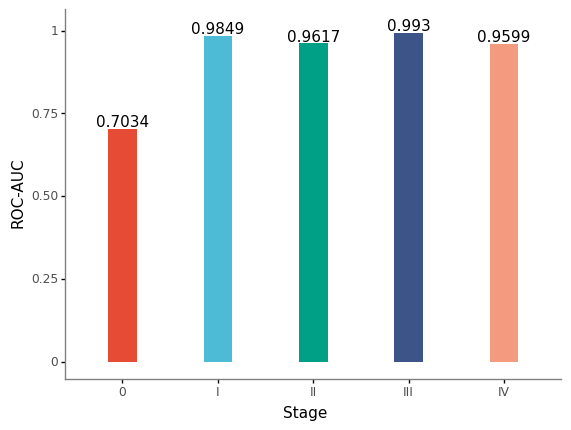

<ggplot: (8737241783248)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3.6 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: CRC_stage_performance.pdf


In [166]:
from plotnine import *
plot = (ggplot(overall, aes(x='Stage', y='ROC-AUC', fill='Stage'))
         + geom_bar(stat='identity', width=0.3, show_legend = False)
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#8491B4FF','#91D1C2FF'])
         + geom_text(aes(label='value'), position=position_dodge(width=0.9), nudge_y=0.02)
         + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
                 axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
       )
print(plot)
plot.save('CRC_stage_performance.pdf', dpi=120, width=3.6, height=4.8)

In [174]:
pd.read_csv('dataFiles/species_abundance.csv', index_col=0).to_csv('dataFiles/species_abundance.tsv', sep='\t')
!ls dataFiles/species_abundance.tsv > tmp
!expert convert -i tmp -o CRC_cm.h5 --in-cm
!for i in {0,1,2,3,4}; do expert search -i CRC_cm.h5 -o CRC_contribution_$i -m ../Disease-diagnosis/experiments/exp_$i/TrainModel; done

running...
Reading and concatenating data, this could be slow if you have huge amount of data
db file: /home/chonghui/.etetoolkit/taxa.sqlite
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]
        ERR475482   ERR475493   ERR475500  ...   ERR481063   ERR481064   ERR481065
count  854.000000  854.000000  854.000000  ...  854.000000  854.000000  854.000000
mean     0.188848    0.155293    0.091492  ...    0.221712    0.225143    0.222403
std      2.274977    1.508092    1.018507  ...    4.716516    4.774864    4.758246
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
max     47.130700   37.035000   24.845200  ...  135.370960  137.099840  136.803670

[6 rows x 635 columns]
Initializing in-memory taxonomy database for ultra-fast querying.
db file: /home/chonghui/.etetoolkit/taxa.sqlite
There will be 0/854 entries droped cause they are not in N